### Курсовая работа к курсу Megafon

### Не завершена, закончу через несколько часов

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

import dask.dataframe as dd
from dask.diagnostics import ProgressBar

In [2]:
val_portion = 0.1
data_path = './data'
model_path = './model'

In [3]:
df_train = pd.read_csv(data_path + '/data_train.csv')
df_test = pd.read_csv(data_path + '/data_test.csv')

In [4]:
df_train

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0
2,2,2458816,1.0,1534107600,0.0
3,3,3535012,5.0,1535922000,0.0
4,4,1693214,1.0,1535922000,0.0
...,...,...,...,...,...
831648,831648,3812226,2.0,1546203600,0.0
831649,831649,2480469,2.0,1546203600,0.0
831650,831650,158236,2.0,1546203600,0.0
831651,831651,1825525,2.0,1546203600,0.0


In [5]:
df_test

,Unnamed: 0,id,vas_id,buy_time
0,0,3130519,2.0,1548018000
1,1,2000860,4.0,1548018000
2,2,1099444,2.0,1546808400
3,3,1343255,5.0,1547413200
4,4,1277040,2.0,1546808400
...,...,...,...,...
71226,71226,2502453,5.0,1548018000
71227,71227,1693213,2.0,1548018000
71228,71228,1891350,2.0,1548018000
71229,71229,2437172,2.0,1548018000


In [6]:
%%time

def load_features(path):
    ddf_features = dd.read_csv(path, sep='\t')

    print('загружаем df_features_short ...')
    with ProgressBar():
        df_features_short = ddf_features[['id', 'buy_time']].compute()

    print('сортируем df_features_short ...')
    df_features_short.sort_values(['buy_time'], inplace=True)
    df_features_short.rename(columns={'buy_time': 'features_buy_time'}, inplace=True)
    return (ddf_features, df_features_short)

ddf_features, df_features_short = load_features(data_path + '/features.csv')

загружаем df_features_short ...
[########################################] | 100% Completed |  4min 54.1s
сортируем df_features_short ...
Wall time: 4min 54s


,id,features_buy_time
9455,1735316,1531083600
11516,2206020,1531083600
5430,1205398,1531083600
10790,3588725,1531083600
3295,2595799,1531083600
...,...,...
10926,4244058,1548018000
10907,4237932,1548018000
6379,1390311,1548018000
6426,1398944,1548018000


In [9]:
def add_features(df):
    if 'features_buy_time' in df.columns and '0' in df.columns:
        print(f'Признаки уже добавлены, размер df {df.shape[0]} x {df.shape[1]}')
        return df

    print(f'Добавляем признаки в df {df.shape[0]} x {df.shape[1]} ...')
    
    print(f'сортируем df {df.shape[0]} x {df.shape[1]} ...')
    df = df.sort_values(['buy_time'])

    print('merge_asof ...')
    df_ft_keys = pd.merge_asof(
            df, 
            df_features_short,
            by='id', 
            left_on='buy_time', right_on='features_buy_time',
            direction='nearest')
    print(f'df_ft_keys: {df_ft_keys.shape[0]} x {df_ft_keys.shape[1]}')

    print('merge ...')
    with ProgressBar():
        ddf_ft = dd.merge(df_ft_keys, ddf_features, left_on=['id', 'features_buy_time'], right_on=['id', 'buy_time'])

    print('compute ...')
    with ProgressBar():
        df_ft = ddf_ft.compute()

    print(f'df_ft: {df_ft.shape[0]} x {df_ft.shape[1]}')
    
    return df_ft

In [8]:
%%time
df_train = add_features(df_train)
df_train.shape

Добавляем признаки в df 831653 x 5 ...
сортируем df 831653 x 5 ...
merge_asof ...
df_ft_keys: 831653 x 6
merge ...
compute ...
[########################################] | 100% Completed |  4min 58.3s
df_ft: 831653 x 261
Wall time: 5min 1s


(831653, 261)

In [105]:
%%time
df_test = add_features(df_test)
df_test.shape

Features already added, number of columns is 260
Wall time: 0 ns


(71231, 260)

In [38]:
df_train.to_pickle(data_path + '/train_with_features.pkl')
df_test.to_pickle(data_path + '/test_with_features.pkl')

In [3]:
df_train = pd.read_pickle(data_path + '/train_with_features.pkl')
df_test = pd.read_pickle(data_path + '/test_with_features.pkl')
df_train

,Unnamed: 0_x,id,vas_id,buy_time_x,target,features_buy_time,Unnamed: 0_y,buy_time_y,0,1,...,243,244,245,246,247,248,249,250,251,252
0,705635,4106046,1.0,1531083600,0.0,1538341200,8754,1538341200,371.420029,74.880888,...,-875.373846,-522.770792,-23.996269,-37.630448,-164.747724,-5.832889,15.305572,-8.175933,-0.45614,0.0
1,480615,3674776,4.0,1531083600,0.0,1532898000,420,1532898000,-96.799971,384.200888,...,-669.373846,-392.770792,-23.996269,-33.630448,-144.747724,-22.832889,-0.694428,-9.175933,-0.45614,1.0
2,607549,174463,4.0,1531083600,0.0,1533502800,10406,1533502800,4.900029,-285.279112,...,-945.373846,-581.770792,-21.996269,-34.630448,-265.747724,-23.832889,1.305572,-12.175933,-0.45614,1.0
3,710294,1932030,4.0,1531083600,0.0,1539550800,5056,1539550800,-86.209971,95.220888,...,6635.626154,6912.229208,-25.996269,-37.630448,-98.747724,-7.832889,-0.694428,-7.175933,-0.45614,0.0
4,712140,4000165,1.0,1531083600,0.0,1547413200,742,1547413200,-96.799971,259.410888,...,-11.373846,-608.770792,-24.996269,-27.630448,-94.747724,-23.832889,-0.694428,-12.175933,-0.45614,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,540697,2036774,6.0,1546203600,0.0,1541970000,4506183,1541970000,85.410029,-55.629112,...,-893.373846,-600.770792,20.003731,-37.630448,-158.747724,-20.832889,1.305572,-12.175933,-0.45614,0.0
2333,550478,690317,7.0,1546203600,0.0,1534712400,4502580,1534712400,-81.969971,331.210888,...,-977.373846,-613.770792,-25.996269,-37.630448,-256.747724,-23.832889,-0.694428,-10.175933,-0.45614,0.0
2334,546621,2820170,2.0,1546203600,0.0,1546203600,4509323,1546203600,-96.799971,-408.179112,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
2335,536294,2407519,2.0,1546203600,0.0,1532898000,4507723,1532898000,161.680029,485.890888,...,16156.626154,-133.770792,-23.996269,-36.630448,1262.252276,79.167111,-0.694428,92.824067,-0.45614,0.0


In [10]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score

def train_val_split(df_train, val_portion=0.1):
    df_train_train = df_train[:int(len(df_train) * (1 - val_portion))]

    X_train_train = df_train_train.drop('target', axis=1)
    y_train_train = df_train_train['target']
    print(f'Тренировочный набор: {X_train_train.shape[0]} x {X_train_train.shape[1]}')

    df_train_val = df_train[int(len(df_train) * (1 - val_portion)):]
    X_train_val = df_train_val.drop('target', axis=1)
    y_train_val = df_train_val['target']
    print(f'Валидационный набор: {X_train_val.shape[0]} x {X_train_val.shape[1]}')

    return X_train_train, X_train_val, y_train_train, y_train_val

def report(y_true, y_proba):
    zero_division = 0
    metrics = np.array([[
                thr, 
                f1_score(y_true, y_proba > thr, zero_division=zero_division),
                precision_score(y_true, y_proba > thr, zero_division=zero_division),
                recall_score(y_true, y_proba > thr, zero_division=zero_division)
                ] for thr in np.linspace(0.00, 1.0, 50)])
    f1_threshold = metrics[np.argmax(metrics[:,1]), 0]
    y_pred = y_proba > f1_threshold
    print(f'y_pred = y_proba > {f1_threshold}')
    f1s = f1_score(y_true, y_pred, zero_division=zero_division)
    f1sm = f1_score(y_true, y_pred, average='macro', zero_division=zero_division)
    ras = roc_auc_score(y_true, y_proba)
    print('F1-score:', f1s)
    print('F1-score-macro:', f1sm)
    print('ROC-AUC-score:', ras)
    
    print(classification_report(y_true, y_pred, zero_division=zero_division))
    print(confusion_matrix(y_true, y_pred))
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr)
    plt.show()
    plt.plot(metrics[:,0], metrics[:,1], label='F1-score')
    plt.plot(metrics[:,0], metrics[:,2], label='precision')
    plt.plot(metrics[:,0], metrics[:,3], label='recall')
    plt.xlabel("Порог вероятности предсказания")
    plt.legend(loc="upper left")
    plt.show()
    return {'f1_threshold': f1_threshold, 'f1_score': f1s, 'f1_score_macro': f1sm, 'roc_auc_score': ras}
    

In [11]:
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression


def column_selector(col_list):
    return ColumnTransformer([("selector", "passthrough", col_list)], remainder="drop")


def asstr(x):
    return x.astype(str)
    

class CallableWithArgs:
    def __init__(self, fn, *args):
        self.fn = fn
        self.args = args

    def __call__(self, fn_arg):
        print(self.args)
        return self.fn(fn_arg, *self.args)


def get_features(df):
    return ['vas_id'] + [c for c in df.columns if c.isnumeric()]

def get_cat_features(df, cat_features):
    features = get_features(df)
    cat_features = [c for c in features if c in cat_features]
    return cat_features
    
def get_num_features(df, cat_features):
    features = get_features(df)
    cat_features = get_cat_features(df, cat_features)
    num_features = [c for c in features if c not in cat_features]
    return num_features

    
def make_feature_pipeline(cat_features):

    
    return Pipeline([
            ('add_features', FunctionTransformer(add_features)),
            ('prepare_features', FeatureUnion([
                ("categorical_features", make_pipeline(
                    column_selector(CallableWithArgs(get_cat_features, cat_features)),
                    SimpleImputer(strategy="most_frequent"),
                    FunctionTransformer(asstr),
                    OneHotEncoder(handle_unknown='ignore')
                )),
                ("numeric_features", make_pipeline(
                    column_selector(CallableWithArgs(get_num_features, cat_features)),
                    SimpleImputer(strategy="mean"),
                    StandardScaler()
                )),
            ])),
            # ухудшает результат
#            ('filter_important_features', SelectFromModel(
#                 LogisticRegression(penalty='l2', random_state=4242), 
#                 threshold=1e-3))
        ])


def make_classifier(features_pipeline,  classifier_object):
    return Pipeline([ 
                ('features', features_pipeline), 
                ('classifier', classifier_object) 
            ])

def to_pickle(pipeline, pickle_path):
    parent_path = os.path.dirname(pickle_path)
    if parent_path and parent_path != '.':
        os.makedirs(parent_path, exist_ok=True)
    print(f'Сохранение в  {pickle_path} ...')
    with open(pickle_path, 'wb') as out_strm:
        pickle.dump(pipeline, out_strm)
    print(f'Сохранение в  {pickle_path} - ok')

def from_pickle(pickle_path):
    print(f'Загрузка из {pickle_path} ...')
    with open(pickle_path, 'rb') as in_strm:
        pipeline = pickle.load(in_strm)    
    print(f'Загрузка из {pickle_path} - ok')
    return pipeline

def iteration(i, classifier, df_train, cat_features=['vas_id']):
    
    classifier_name = type(classifier).__name__
    print(f"Итерация {i} с классификатором {classifier_name}, {len(cat_features)} категориальных признаков")
    
    print("Разделяем тренировочный набор ...")
    X_train_train, X_train_val, y_train_train, y_train_val = train_val_split(df_train, val_portion=val_portion)

    print(f"X_train_train: {X_train_train.shape[0]} x {X_train_train.shape[1]}")
    print(f"y_train_train: {y_train_train.shape[0]}")
    print(f"X_train_val: {X_train_val.shape[0]} x {X_train_val.shape[1]}")
    print(f"y_train_val: {y_train_val.shape[0]}")
    
    print("Создаем pipeline ...")
    feature_prep_pipeline = make_feature_pipeline(cat_features)
    pipeline = make_classifier(feature_prep_pipeline, classifier)

    print("Тренируем ...")
    pipeline.fit(X_train_train, y_train_train)

    pickle_path = f'{model_path}/{classifier_name}_{i}.pkl'
    to_pickle(pipeline, pickle_path)
    from_pickle(pickle_path)
    
    print("Получаем предсказания ...")
    y_train_proba = pipeline.predict_proba(X_train_val)[:,1]

    print(" ------------------------ Отчет: ------------------------ ")
    metrics = report(y_train_val, y_train_proba)
    
    return {
        'pipeline': pipeline, 
        'classifier': classifier, 
        'cat_features': cat_features, 
        'metrics': metrics
    }



Итерация 0 с классификатором CatBoostClassifier, 1 категориальных признаков
Разделяем тренировочный набор ...
Тренировочный набор: 748487 x 260
Валидационный набор: 83166 x 260
X_train_train: 748487 x 260
y_train_train: 748487
X_train_val: 83166 x 260
y_train_val: 83166
Создаем pipeline ...
Тренируем ...
Признаки уже добавлены, размер df 748487 x 260
(['vas_id'],)
(['vas_id'],)
Learning rate set to 0.173864
0:	learn: 0.4449047	total: 351ms	remaining: 5m 50s
1:	learn: 0.3143133	total: 542ms	remaining: 4m 30s
2:	learn: 0.2570162	total: 705ms	remaining: 3m 54s
3:	learn: 0.2234485	total: 897ms	remaining: 3m 43s
4:	learn: 0.1950712	total: 1.08s	remaining: 3m 34s
5:	learn: 0.1841212	total: 1.22s	remaining: 3m 21s
6:	learn: 0.1728706	total: 1.4s	remaining: 3m 18s
7:	learn: 0.1686514	total: 1.54s	remaining: 3m 11s
8:	learn: 0.1636769	total: 1.71s	remaining: 3m 7s
9:	learn: 0.1607902	total: 1.88s	remaining: 3m 5s
10:	learn: 0.1597298	total: 2.01s	remaining: 3m
11:	learn: 0.1582635	total: 2.17s	

150:	learn: 0.1533907	total: 26.2s	remaining: 2m 27s
151:	learn: 0.1533866	total: 26.3s	remaining: 2m 26s
152:	learn: 0.1533742	total: 26.5s	remaining: 2m 26s
153:	learn: 0.1533585	total: 26.7s	remaining: 2m 26s
154:	learn: 0.1533457	total: 26.9s	remaining: 2m 26s
155:	learn: 0.1533270	total: 27s	remaining: 2m 26s
156:	learn: 0.1533142	total: 27.2s	remaining: 2m 25s
157:	learn: 0.1532965	total: 27.3s	remaining: 2m 25s
158:	learn: 0.1532800	total: 27.5s	remaining: 2m 25s
159:	learn: 0.1532638	total: 27.6s	remaining: 2m 25s
160:	learn: 0.1532594	total: 27.8s	remaining: 2m 24s
161:	learn: 0.1532470	total: 28s	remaining: 2m 24s
162:	learn: 0.1532316	total: 28.1s	remaining: 2m 24s
163:	learn: 0.1532153	total: 28.3s	remaining: 2m 24s
164:	learn: 0.1532045	total: 28.5s	remaining: 2m 24s
165:	learn: 0.1531879	total: 28.7s	remaining: 2m 24s
166:	learn: 0.1531797	total: 28.8s	remaining: 2m 23s
167:	learn: 0.1531702	total: 28.9s	remaining: 2m 23s
168:	learn: 0.1531639	total: 29.1s	remaining: 2m 2

307:	learn: 0.1515124	total: 51.1s	remaining: 1m 54s
308:	learn: 0.1515105	total: 51.3s	remaining: 1m 54s
309:	learn: 0.1514904	total: 51.4s	remaining: 1m 54s
310:	learn: 0.1514708	total: 51.6s	remaining: 1m 54s
311:	learn: 0.1514612	total: 51.8s	remaining: 1m 54s
312:	learn: 0.1514445	total: 51.9s	remaining: 1m 53s
313:	learn: 0.1514422	total: 52.1s	remaining: 1m 53s
314:	learn: 0.1514374	total: 52.2s	remaining: 1m 53s
315:	learn: 0.1514276	total: 52.4s	remaining: 1m 53s
316:	learn: 0.1514236	total: 52.5s	remaining: 1m 53s
317:	learn: 0.1514123	total: 52.6s	remaining: 1m 52s
318:	learn: 0.1514066	total: 52.8s	remaining: 1m 52s
319:	learn: 0.1513995	total: 53s	remaining: 1m 52s
320:	learn: 0.1513810	total: 53.2s	remaining: 1m 52s
321:	learn: 0.1513744	total: 53.4s	remaining: 1m 52s
322:	learn: 0.1513693	total: 53.5s	remaining: 1m 52s
323:	learn: 0.1513615	total: 53.6s	remaining: 1m 51s
324:	learn: 0.1513470	total: 53.8s	remaining: 1m 51s
325:	learn: 0.1513375	total: 54s	remaining: 1m 5

462:	learn: 0.1498741	total: 1m 15s	remaining: 1m 27s
463:	learn: 0.1498572	total: 1m 15s	remaining: 1m 27s
464:	learn: 0.1498393	total: 1m 15s	remaining: 1m 27s
465:	learn: 0.1498365	total: 1m 15s	remaining: 1m 26s
466:	learn: 0.1498231	total: 1m 16s	remaining: 1m 26s
467:	learn: 0.1498145	total: 1m 16s	remaining: 1m 26s
468:	learn: 0.1498051	total: 1m 16s	remaining: 1m 26s
469:	learn: 0.1497917	total: 1m 16s	remaining: 1m 26s
470:	learn: 0.1497828	total: 1m 16s	remaining: 1m 26s
471:	learn: 0.1497697	total: 1m 16s	remaining: 1m 25s
472:	learn: 0.1497520	total: 1m 17s	remaining: 1m 25s
473:	learn: 0.1497483	total: 1m 17s	remaining: 1m 25s
474:	learn: 0.1497413	total: 1m 17s	remaining: 1m 25s
475:	learn: 0.1497241	total: 1m 17s	remaining: 1m 25s
476:	learn: 0.1497171	total: 1m 17s	remaining: 1m 25s
477:	learn: 0.1497050	total: 1m 17s	remaining: 1m 25s
478:	learn: 0.1496899	total: 1m 17s	remaining: 1m 24s
479:	learn: 0.1496756	total: 1m 18s	remaining: 1m 24s
480:	learn: 0.1496689	total:

615:	learn: 0.1483015	total: 1m 40s	remaining: 1m 2s
616:	learn: 0.1482919	total: 1m 40s	remaining: 1m 2s
617:	learn: 0.1482752	total: 1m 40s	remaining: 1m 2s
618:	learn: 0.1482614	total: 1m 40s	remaining: 1m 2s
619:	learn: 0.1482559	total: 1m 41s	remaining: 1m 1s
620:	learn: 0.1482549	total: 1m 41s	remaining: 1m 1s
621:	learn: 0.1482427	total: 1m 41s	remaining: 1m 1s
622:	learn: 0.1482258	total: 1m 41s	remaining: 1m 1s
623:	learn: 0.1482122	total: 1m 41s	remaining: 1m 1s
624:	learn: 0.1481983	total: 1m 41s	remaining: 1m 1s
625:	learn: 0.1481976	total: 1m 42s	remaining: 1m
626:	learn: 0.1481823	total: 1m 42s	remaining: 1m
627:	learn: 0.1481713	total: 1m 42s	remaining: 1m
628:	learn: 0.1481595	total: 1m 42s	remaining: 1m
629:	learn: 0.1481556	total: 1m 42s	remaining: 1m
630:	learn: 0.1481409	total: 1m 42s	remaining: 1m
631:	learn: 0.1481274	total: 1m 42s	remaining: 60s
632:	learn: 0.1481099	total: 1m 43s	remaining: 59.8s
633:	learn: 0.1480966	total: 1m 43s	remaining: 59.7s
634:	learn: 0

772:	learn: 0.1467631	total: 2m 6s	remaining: 37s
773:	learn: 0.1467580	total: 2m 6s	remaining: 36.9s
774:	learn: 0.1467511	total: 2m 6s	remaining: 36.7s
775:	learn: 0.1467495	total: 2m 6s	remaining: 36.6s
776:	learn: 0.1467363	total: 2m 6s	remaining: 36.4s
777:	learn: 0.1467199	total: 2m 7s	remaining: 36.2s
778:	learn: 0.1467037	total: 2m 7s	remaining: 36.1s
779:	learn: 0.1466915	total: 2m 7s	remaining: 35.9s
780:	learn: 0.1466890	total: 2m 7s	remaining: 35.8s
781:	learn: 0.1466878	total: 2m 7s	remaining: 35.6s
782:	learn: 0.1466785	total: 2m 7s	remaining: 35.4s
783:	learn: 0.1466759	total: 2m 7s	remaining: 35.2s
784:	learn: 0.1466626	total: 2m 8s	remaining: 35.1s
785:	learn: 0.1466570	total: 2m 8s	remaining: 34.9s
786:	learn: 0.1466421	total: 2m 8s	remaining: 34.8s
787:	learn: 0.1466312	total: 2m 8s	remaining: 34.6s
788:	learn: 0.1466272	total: 2m 8s	remaining: 34.4s
789:	learn: 0.1466222	total: 2m 8s	remaining: 34.3s
790:	learn: 0.1466022	total: 2m 9s	remaining: 34.1s
791:	learn: 0.

929:	learn: 0.1452384	total: 2m 32s	remaining: 11.5s
930:	learn: 0.1452313	total: 2m 32s	remaining: 11.3s
931:	learn: 0.1452195	total: 2m 32s	remaining: 11.2s
932:	learn: 0.1452091	total: 2m 33s	remaining: 11s
933:	learn: 0.1452017	total: 2m 33s	remaining: 10.8s
934:	learn: 0.1451959	total: 2m 33s	remaining: 10.7s
935:	learn: 0.1451882	total: 2m 33s	remaining: 10.5s
936:	learn: 0.1451850	total: 2m 33s	remaining: 10.3s
937:	learn: 0.1451833	total: 2m 33s	remaining: 10.2s
938:	learn: 0.1451659	total: 2m 34s	remaining: 10s
939:	learn: 0.1451478	total: 2m 34s	remaining: 9.85s
940:	learn: 0.1451306	total: 2m 34s	remaining: 9.69s
941:	learn: 0.1451175	total: 2m 34s	remaining: 9.53s
942:	learn: 0.1451156	total: 2m 34s	remaining: 9.36s
943:	learn: 0.1451090	total: 2m 35s	remaining: 9.2s
944:	learn: 0.1450936	total: 2m 35s	remaining: 9.03s
945:	learn: 0.1450796	total: 2m 35s	remaining: 8.87s
946:	learn: 0.1450677	total: 2m 35s	remaining: 8.7s
947:	learn: 0.1450620	total: 2m 35s	remaining: 8.54s

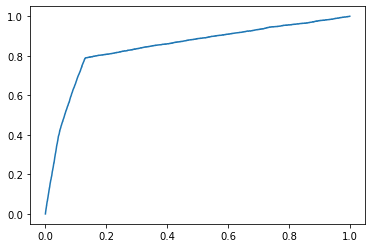

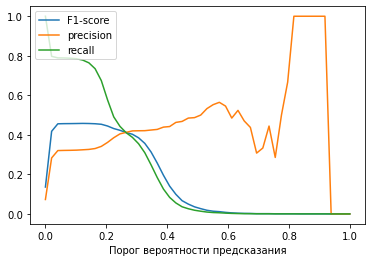

Wall time: 3min 14s


In [12]:
%%time

r = iteration(0, CatBoostClassifier(class_weights=[0.93, 0.7]), df_train)


In [188]:
r['metrics']

{'f1_threshold': 0.12244897959183673,
 'f1_score': 0.0032819994950770014,
 'f1_score_macro': 0.4767183307241183,
 'roc_auc_score': 0.4987520925155022}

In [100]:
df_train


,Unnamed: 0_x,id,vas_id,buy_time_x,target,features_buy_time,Unnamed: 0_y,buy_time_y,0,1,...,243,244,245,246,247,248,249,250,251,252
0,705635,4106046,1.0,1531083600,0.0,1538341200,8754,1538341200,371.420029,74.880888,...,-875.373846,-522.770792,-23.996269,-37.630448,-164.747724,-5.832889,15.305572,-8.175933,-0.45614,0.0
1,480615,3674776,4.0,1531083600,0.0,1532898000,420,1532898000,-96.799971,384.200888,...,-669.373846,-392.770792,-23.996269,-33.630448,-144.747724,-22.832889,-0.694428,-9.175933,-0.45614,1.0
2,607549,174463,4.0,1531083600,0.0,1533502800,10406,1533502800,4.900029,-285.279112,...,-945.373846,-581.770792,-21.996269,-34.630448,-265.747724,-23.832889,1.305572,-12.175933,-0.45614,1.0
3,710294,1932030,4.0,1531083600,0.0,1539550800,5056,1539550800,-86.209971,95.220888,...,6635.626154,6912.229208,-25.996269,-37.630448,-98.747724,-7.832889,-0.694428,-7.175933,-0.45614,0.0
4,712140,4000165,1.0,1531083600,0.0,1547413200,742,1547413200,-96.799971,259.410888,...,-11.373846,-608.770792,-24.996269,-27.630448,-94.747724,-23.832889,-0.694428,-12.175933,-0.45614,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,540697,2036774,6.0,1546203600,0.0,1541970000,4506183,1541970000,85.410029,-55.629112,...,-893.373846,-600.770792,20.003731,-37.630448,-158.747724,-20.832889,1.305572,-12.175933,-0.45614,0.0
2333,550478,690317,7.0,1546203600,0.0,1534712400,4502580,1534712400,-81.969971,331.210888,...,-977.373846,-613.770792,-25.996269,-37.630448,-256.747724,-23.832889,-0.694428,-10.175933,-0.45614,0.0
2334,546621,2820170,2.0,1546203600,0.0,1546203600,4509323,1546203600,-96.799971,-408.179112,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
2335,536294,2407519,2.0,1546203600,0.0,1532898000,4507723,1532898000,161.680029,485.890888,...,16156.626154,-133.770792,-23.996269,-36.630448,1262.252276,79.167111,-0.694428,92.824067,-0.45614,0.0


In [199]:
r_bad=r



In [206]:
X_train_train, X_train_val, y_train_train, y_train_val = train_val_split(df_train, val_portion=val_portion)

y_pred = r['pipeline'].predict_proba(X_train_val)[:,1]


Тренировочный набор: 748487 x 260
Валидационный набор: 83166 x 260
Признаки уже добавлены, размер df 83166 x 260


[0.01621013 0.01166123 0.00959092 ... 0.01528393 0.01131118 0.01357303]
y_pred = y_proba > 0.12244897959183673
F1-score: 0.4578827408952039
F1-score-macro: 0.69058119173769
ROC-AUC-score: 0.8431906123005778
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92     77100
         1.0       0.32      0.78      0.46      6066

    accuracy                           0.87     83166
   macro avg       0.65      0.83      0.69     83166
weighted avg       0.93      0.87      0.89     83166

[[67266  9834]
 [ 1345  4721]]


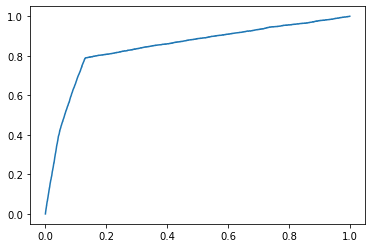

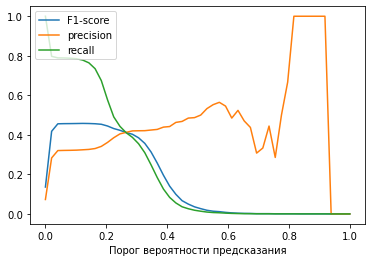

{'f1_threshold': 0.12244897959183673,
 'f1_score': 0.4578827408952039,
 'f1_score_macro': 0.69058119173769,
 'roc_auc_score': 0.8431906123005778}

In [207]:
print(y_pred)
report(y_train_val, y_pred)